In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Parameters
lr = 0.01
momentum = 0.5
batch_size = 64
test_batch_size = 1000
epochs = 10
log_interval = 10
sgd_momentum = 0.5
use_cuda = True if torch.cuda.is_available() else False

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [4]:
model = Net()
if use_cuda:
    model.cuda()

In [5]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [6]:
params = list(model.parameters())
print(len(params))
print(params[0].size()) # conv1's .weight

8
torch.Size([10, 1, 5, 5])


In [7]:
from torchvision import datasets, transforms

kwargs = {'num_workers': 1, 'pin_memory': True}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Files already downloaded


In [8]:
from torch.autograd import Variable

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)        
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [9]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    accuracy = correct/len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * accuracy))
    log_value('test_acc', accuracy, epoch)
    log_value('test_loss', test_loss, epoch)

In [10]:
from tensorboard_logger import configure, log_value
configure("runs/mnist_cnn")

In [11]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.299604
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.317195
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.307757
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.308277
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.293038
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248775
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.242738
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.238546
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.199243
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.198918
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.129225
Train Epoch: 1 [7040/60000 (12%)]	Loss: 2.111327
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.931690
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.822012
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.673318
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.695896
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.474215
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.412020
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.227377
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.353258
Train Epoch: 1 [12800/60000 (

In [12]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

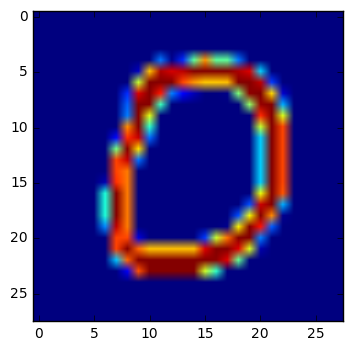

In [13]:
img = test_loader.dataset[10][0][0].numpy()
imgplot = plt.imshow(img)